In [1]:
import sys; sys.path.insert(0, '../../')
from definitions import *

In [2]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from src.visualization.general import missing_values_barplot, remove_plot_ticks
from src.data.dataset import TimeSeriesDataset

# Prediction of Sepsis from ICU Data
This short notebook will guide you through the basics of our methodology to predicting sepsis from the physionet 2019 challenge data.

## Data
First lets have a quick look at the data

In [4]:
# Load
df = load_pickle(DATA_DIR + '/raw/df.pickle')
labels_binary = load_pickle(DATA_DIR + '/processed/labels/binary.pickle')
labels_utility = load_pickle(DATA_DIR + '/processed/labels/utility_scores.pickle')

In [6]:
df.head()

,id,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,...,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,hospital,SepsisLabel
0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,46.35,0.0,NaN,NaN,-22.54,1.0,1,0.0
1,0,1,121.0,94.0,NaN,101.0,80.33,NaN,33.0,NaN,...,NaN,NaN,46.35,0.0,NaN,NaN,-22.54,2.0,1,0.0
2,0,2,116.0,95.0,NaN,105.0,77.67,NaN,23.0,NaN,...,NaN,NaN,46.35,0.0,NaN,NaN,-22.54,3.0,1,0.0
3,0,3,114.0,96.0,36.0,80.0,68.00,NaN,20.0,NaN,...,NaN,NaN,46.35,0.0,NaN,NaN,-22.54,4.0,1,0.0
4,0,4,110.0,88.0,NaN,91.5,73.17,NaN,21.0,NaN,...,NaN,NaN,46.35,0.0,NaN,NaN,-22.54,5.0,1,0.0


### Missingness

It is instructive to look at the proprtion of each of the values in the data. The data falls into the following categories:

> Demographics: Fully filled and not time-dependent. Includes things like 'Gender', 'Age', 'hospital'.

> Vitals signs: Regularly filled. 'HR', 'MAP', 'O2Sat', 'SBP', 'DBP', 'Resp', 'Temp'.

> Laboratory values: Infrequently measured values. Everything from 'Glucose' in the plot below. We see that in general, well under 10% of values are filled. 

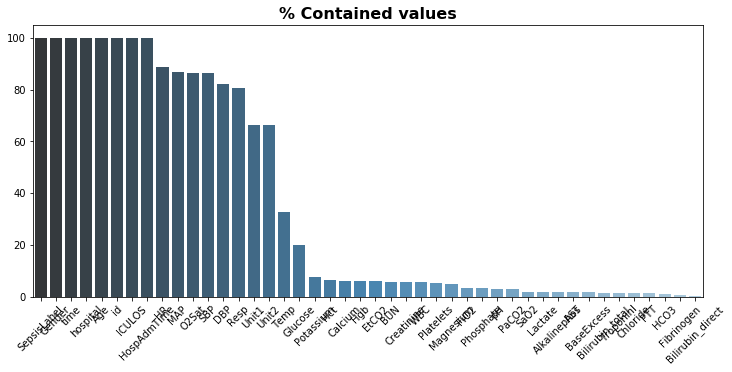

In [7]:
missing_values_barplot(df, missing=False)

### Some example data
Below we plot heart rate (vital sign) and calcium (laboratory value) for a random patient. 

Text(0, 0.5, 'Calcium')

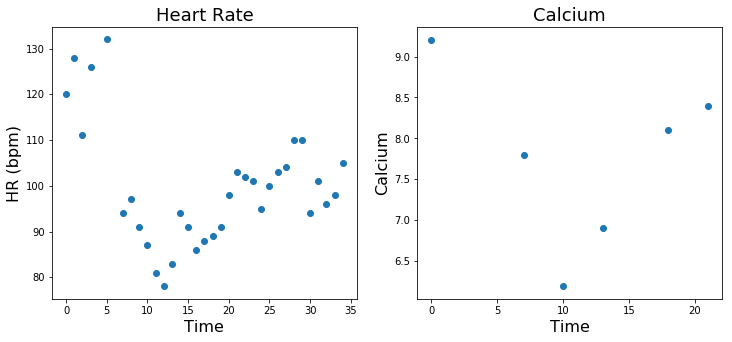

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Get person and time
person = df[df['id'] == 1]
tt = range(person.shape[0])

# Plot HR and 
ax[0].scatter(tt, person['HR'])
ax[1].scatter(tt, person['Calcium'])

# Plot info
ax[0].set_title('Heart Rate', fontsize=18)
ax[0].set_xlabel('Time', fontsize=16)
ax[0].set_ylabel('HR (bpm)', fontsize=16)

ax[1].set_title('Calcium', fontsize=18)
ax[1].set_xlabel('Time', fontsize=16)
ax[1].set_ylabel('Calcium', fontsize=16)

## Converting the Ragged Data
One of the main challenges with this dataset is that time length of the timeseries is different for different patients. This means that it cannot be stored in a tensor that would allow for fast matrix operations. 

One simple alternative would be to use a pandas dataframe that can store the id and time values for each patient, when operations need to be applied for each patients timeseries, the pandas groupby operation can be used.

This was originally what we used in the challenge. However it is extremely slow and I have since realised that a more efficient approach (but by no means the most efficient) is to create a new data structure (that we are calling a TimeSeriesDataset, but really it is a RaggedTimeSeriesDataset), that converts the data into a tensor format by extending everyones time-series to the same size as the maximum length time-series in the data filling in all values past the final time as nan.

The structure keeps track of the original lengths, so we can always convert back, and also keeps track of the columns, so we can apply operations only on certain features. This is also going to be very important.

In [9]:
# Load the dataset
dataset = TimeSeriesDataset().load(DATA_DIR + '/raw/data.tsd')

This data has shape [N, L, C] where:

    - N: Number of patients.
    - L: Length of the time-series. 
    - C: Number of channels, or features. 
However now L is made to be L_max, where L_max is the maximum length of the patient stay.

In [10]:
dataset.data.size()

torch.Size([473, 327, 41])

For example here we see the patients data finishes immediately before the first in the string of nans to the end of the array.

In [11]:
dataset.data[0, :, 0]

tensor([ nan, 121., 116., 114., 110., 125.,  nan, 115., 128., 113., 140., 120.,
        106., 113., 106., 135., 130., 104., 110., 116., 123., 109., 115., 109.,
        104., 119.,  nan, 124., 139., 142., 145., 151., 130., 135., 112., 123.,
        113., 111., 107., 122., 117., 111., 105., 113., 105.,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  n

This structure allows us to get information from each feature, and add information to it, for example:

`dataset['HR']` will get the heart rate data for all patients. 

`dataset['new_feature'] = dataset['HR'] + dataset['SBP']` will create a new feature, called 'new_feature', that is the sum of the heart rate and systolic blood pressure. 

# Model Building
Now we describe the steps in feature extraction and model training to generate predictions. 

## Step 1: Missing Data

There are a huge number of ways for which we could possibly deal with missing data. For the purposes of this notebook, we will simply forward fill any missing values to make our anlaysis easier.

In [12]:
from src.data.functions import torch_ffill

In [13]:
dataset.data = torch_ffill(dataset.data)

## Step 2: Expert Features
The next step is to derive features held in 'expert knowledge'. That is, anything that is already known clinically thought to be important in detecting sepsis that can be derived from out dataset. 

For example:

- `ShockIndex = Heart Rate / Systolic Blood Pressure`: Was found in a sepsis detection paper (https://stm.sciencemag.org/content/7/299/299ra122) to be a more useful indicator than heart rate or SBP alone. 

We add two features for now.

In [14]:
from src.features.derived_features import shock_index, partial_sofa

In [15]:
dataset['ShockIndex'] = shock_index(dataset)
dataset['PartialSOFA'] = partial_sofa(dataset)

## Step 3: Rolling Statistics
We now wish to extract some time-series features from the data. To do this, we consider a rolling window that runs along each patients time-series and pick some statistic to compute for each window. That statistic over that window is then added to the patients feature set.

In [16]:
from src.features.rolling import RollingStatistic

Lets take the maximum of the systolic blood pressure over a 5 hour window, and the minimum of the heart rate over an 8 hour window. 

In [17]:
dataset['MaxShockIndex'] = RollingStatistic(statistic='max', window_length=5).transform(dataset['SBP'])
dataset['MinHR'] = RollingStatistic(statistic='min', window_length=8).transform(dataset['HR'])

## Step 4: Rolling Signature
Whilst technically this can be considered as part of step 3, given that the focus of our prediction methodology was to evaluate if we could improve performance with the signature, we give this its own section. 

In [18]:
# I have issues with signatory in jupyter, so I am not sure if this section will run. It is not necessary for the rest of the script. 
from src.features.signatures.augmentations import apply_augmentation_list
from src.features.signatures.compute import RollingSignature

ModuleNotFoundError: No module named 'signatory'

First lets add the signatures of 'ShockIndex' and 'HeartRate' with an 'addtime' augmentation. 

In [ ]:
# Now some rolling signatures
rolling_signature = RollingSignature(window=6, depth=3, logsig=True, aug_list=['addtime'])
signatures = rolling_signature.transform(dataset[['PartialSOFA', 'ShockIndex']])

# As the signature produces multiple new features, we use the 'add_features' method of the dataset class to add multiple features at once.
dataset.add_features(signatures)

Lets also add the log-signatures of 'PartialSofa' and 'SBP' with the 'addtime' and 'penoff' augmentations over a 10 hour window. 

In [ ]:
# Now some rolling signatures
rolling_signature = RollingSignature(window=10, depth=3, logsig=True, aug_list=['addtime', 'penoff'])
signatures = rolling_signature.transform(dataset[['PartialSOFA', 'HR']])

# As the signature produces multiple new features, we use the 'add_features' method of the dataset class to add multiple features at once.
dataset.add_features(signatures)

## Step 5: Train a Model
Now we have extracted all the features we wish to use, we need to train a supervised model on the data.

The dataset class comes equipped with the following methods:

- **dataset.to_ml()**: This converts the data into a single tensor of shape [N_timepoints, N_features] where N_timepoints is the total number of timepoints over all patients and hours (it automatically removes the additional timepoints created by converting to a tensor of length L_max). This is most useful for standard ML sklearn type models.
- **dataset.to_list()**: This gives a list of tensors of length [L_i, N_features] where each list entry is a tensor for a given patient, and L_i is the length of that patients stay. This format is more useful if one is using a time-dependent model and require the time-series structure to be kept. 

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, KFold

In [21]:
# Get ML form of the data
X = dataset.to_ml()
y = labels_binary
assert len(X) == len(y)    # Sanity check

In [34]:
# Fill the nans
X[torch.isnan(X)] = -1000

In [35]:
# Choose cross val method
cv = list(KFold(5).split(X))

In [41]:
# Train and predict
clf = RandomForestClassifier()
probas = cross_val_predict(clf, X, y, cv=cv, method='predict_proba')

## Step 6: Evaluate

In [52]:
from sklearn.metrics import accuracy_score, roc_auc_score

In [54]:
preds = (probas[:, 1] > 0.5).astype(int)
acc = accuracy_score(y, preds)
auc = roc_auc_score(y, probas[:, 1])

In [59]:
print('Accuracy: {:.3f}% \nAUC: {:.3f}'.format(acc * 100, auc))

Accuracy: 98.046% 
AUC: 0.762
